# Earth Engine for gathering data

Google Earth Engine is a powerful tool for geospatial data analysis. Here, we will discuss how to use its Python API for gathering data from Landsat, Sentinel, and NAIP imagery.

To start off with, request access to Google Earth Engine at: [](https://earthengine.google.com/). This may take some time. Once approved, install the Python API and get credentials for using the API following [these instructions](https://developers.google.com/earth-engine/guides/python_install-conda#mac_6). Be sure to try out the test code they suggest to make sure Earth Engine is running successfully):

In [1]:
import numpy as np
import zipfile
import rasterio
import matplotlib.pyplot as plt
import cv2
import math
from geetools import batch

In [2]:
import ee

# Initialize the Earth Engine module.
ee.Initialize()

If the above code yields output, you'll know you're ready for to go!

## Selecting imagery



In [11]:
def download_S2_toLocal(bbox, name, scale=1):
    """
    downloads Sentinel 2 imagery from the specified bounding box and saves it as `name`
    """
    AOI = ee.Geometry.Rectangle(list(bbox), "EPSG:4326", False)

    collection = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterDate('2020-10-01', '2020-10-10')
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
        .filterBounds(AOI)
        .select(['B2', 'B3', 'B4'])
    )

    image = ee.Image(collection.mosaic()).clip(AOI)
    batch.image.toLocal(image, name, scale=scale, region=AOI)
    return collection

# center of image (base of plant)
x = 33.6319
y = -87.0597

# lat long of image
# will vary based on the surface of the earth
lat = [x-0.004, x+0.004]
lon = [y-0.004, y+0.004]
bbox = [lon[0], lat[0], lon[1], lat[1]]
name = 's2sample4'
image = download_S2_toLocal(bbox, name, scale=1)

In [12]:
path_to_zip_file = 's2sample4.zip'
directory_to_extract_to = 's2sample4'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [13]:
def stack_bands_s2(name, outname):
    file_list = [name + '.B4.tif', name + '.B3.tif', name + '.B2.tif']

    # Read metadata of first file
    with rasterio.open(file_list[0]) as src0:
        meta = src0.meta

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer and write it to stack
    with rasterio.open(outname, 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

outname = "stacked_s2_sample4.tif"
stack_bands_s2('s2sample4/download',outname)

### James H Miller Jr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


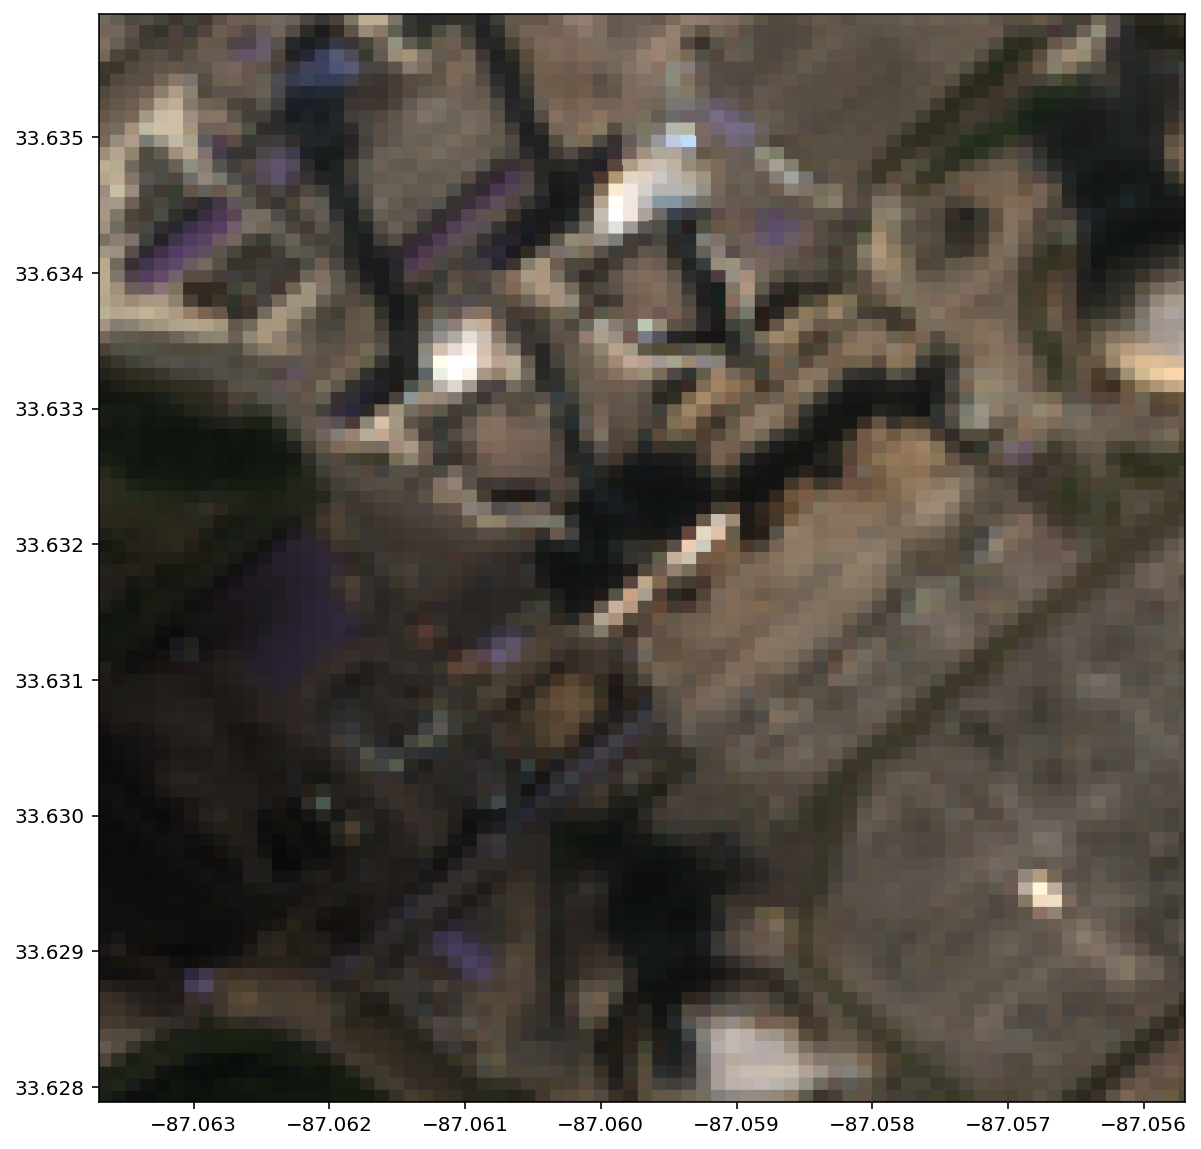

In [14]:
outname = "stacked_s2_sample4.tif"
# Plot the example
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from rasterio.plot import show

fig, ax = plt.subplots(num='main', figsize=(10,10))

from rasterio.plot import show
data = rasterio.open(outname)

# show(data.read([1,2,3]).astype('float')/4096, transform=data.transform, ax=ax)
show(data.read([1,2,3]).astype('float')/4096, transform=data.transform, ax=ax)
plt.savefig(r'hardin.jpg')

# show(data.read([1,2,3]).astype('float')/255, transform=data.transform, ax=ax)

# Image Segmentation

## Load Image as NumPy Array

In [20]:
# load image as numpy array
with rasterio.open('stacked_s2_sample4.tif') as ds:
    img_arr = ds.read()  # read all raster values
img_arr = np.moveaxis(img_arr, 0, -1)
img_arr = img_arr/4096

In [21]:
img_arr.shape

(892, 891, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


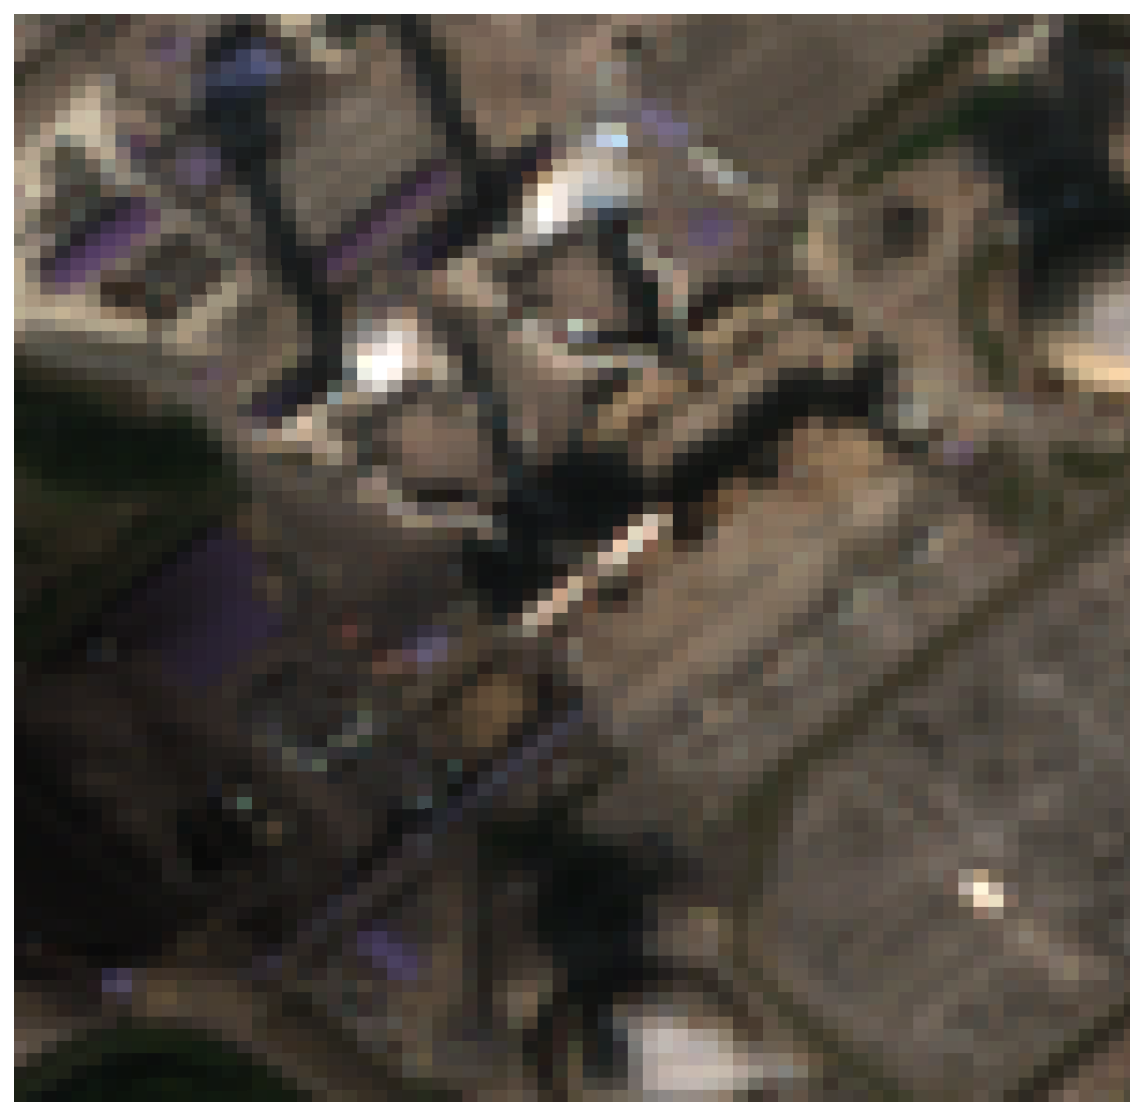

In [23]:
# try numpy swap axis, use this --> *move axis, roll axis
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(img_arr, aspect = 'auto')
plt.show()

## Convert image to grayscale

In [30]:
# take average of each band -- create grayscale image
img_arr_bw = np.average(img_arr, weights=[0.1140, 0.5870, 0.2989], axis=2)
img_arr_bw.shape

(892, 891)

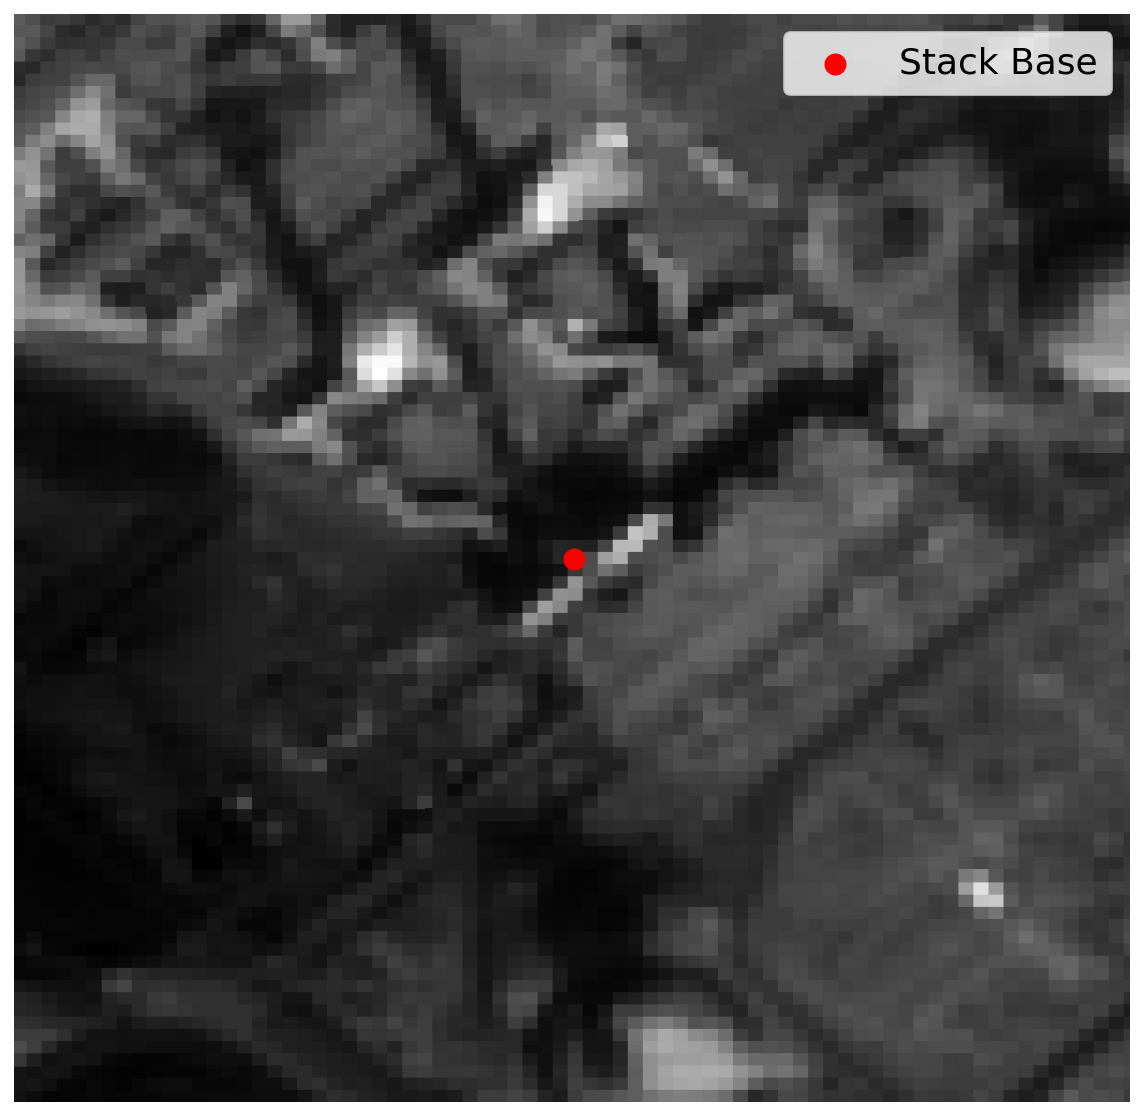

In [74]:
# position of stack base pixel
stack_x = round(img_arr_bw.shape[1]/2)
stack_y = round(img_arr_bw.shape[0]/2)

# true color of averaged image
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(img_arr_bw, aspect = 'auto', cmap ='gray')
plt.scatter(stack_x, stack_y, c='red', s=100, label='Stack Base')
plt.legend(fontsize=18)
plt.show()

## Thresholding images

### Manually create threshold

In [41]:
# select threshold
img_seg = np.where(img_arr_bw < 0.24, 0, 1)

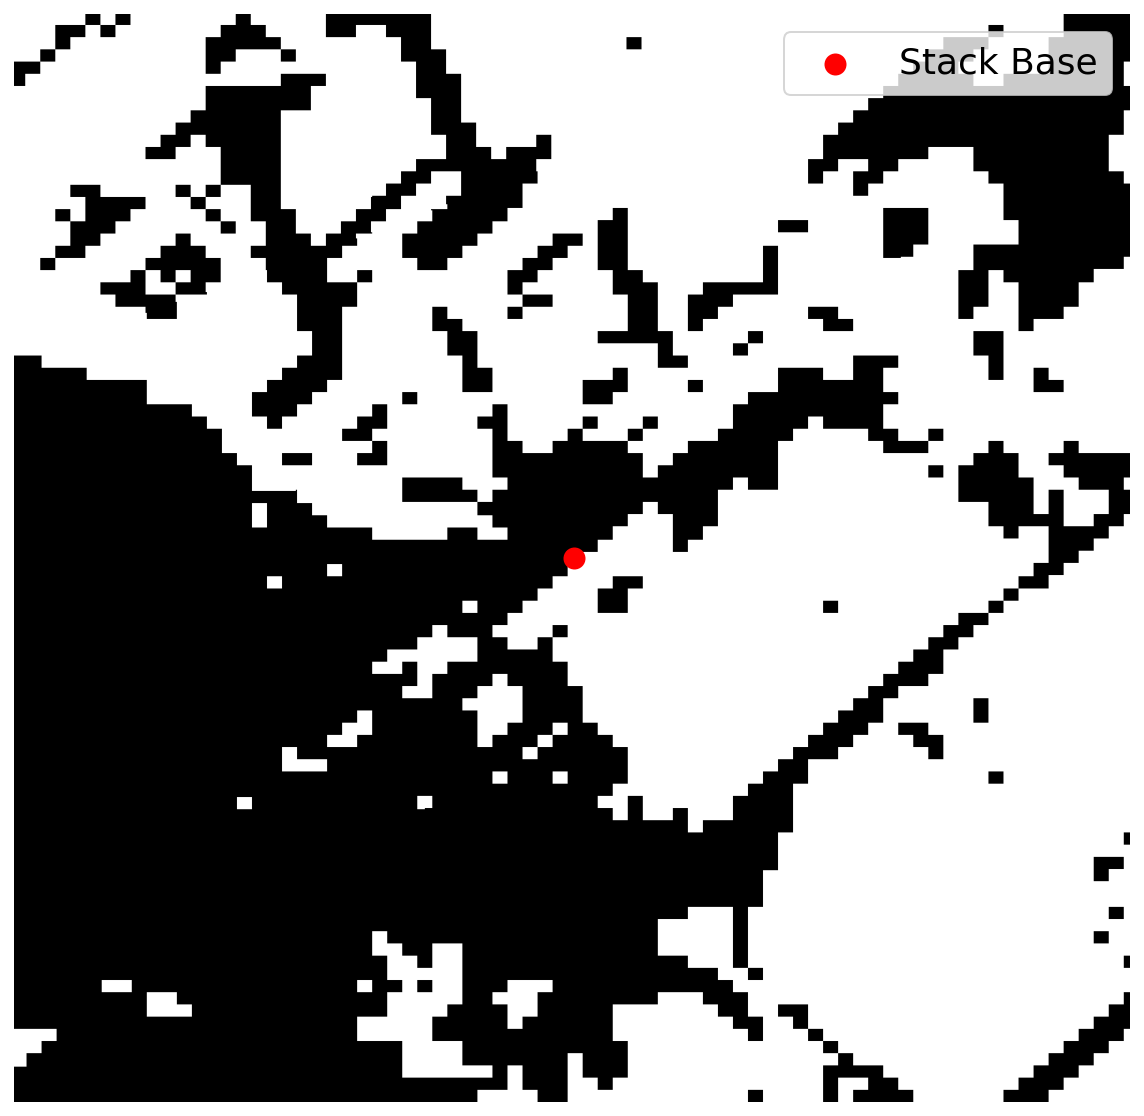

In [44]:
fig, ax = plt.subplots(num='main', figsize=(10,10))
plt.axis('off')
plt.imshow(img_seg, aspect = 'auto', cmap ='gray')
plt.scatter(stack_x, stack_y, c='red', s=100, label='Stack Base')
plt.legend(fontsize=18)
plt.show()

### Thresholding Scikit Learn

Histogram-based: The histogram of the pixels’ intensity is used and certain assumptions are made on the properties of this histogram (e.g. bimodal).

Local: To process a pixel, only the neighboring pixels are used. These algorithms often require more computation time.

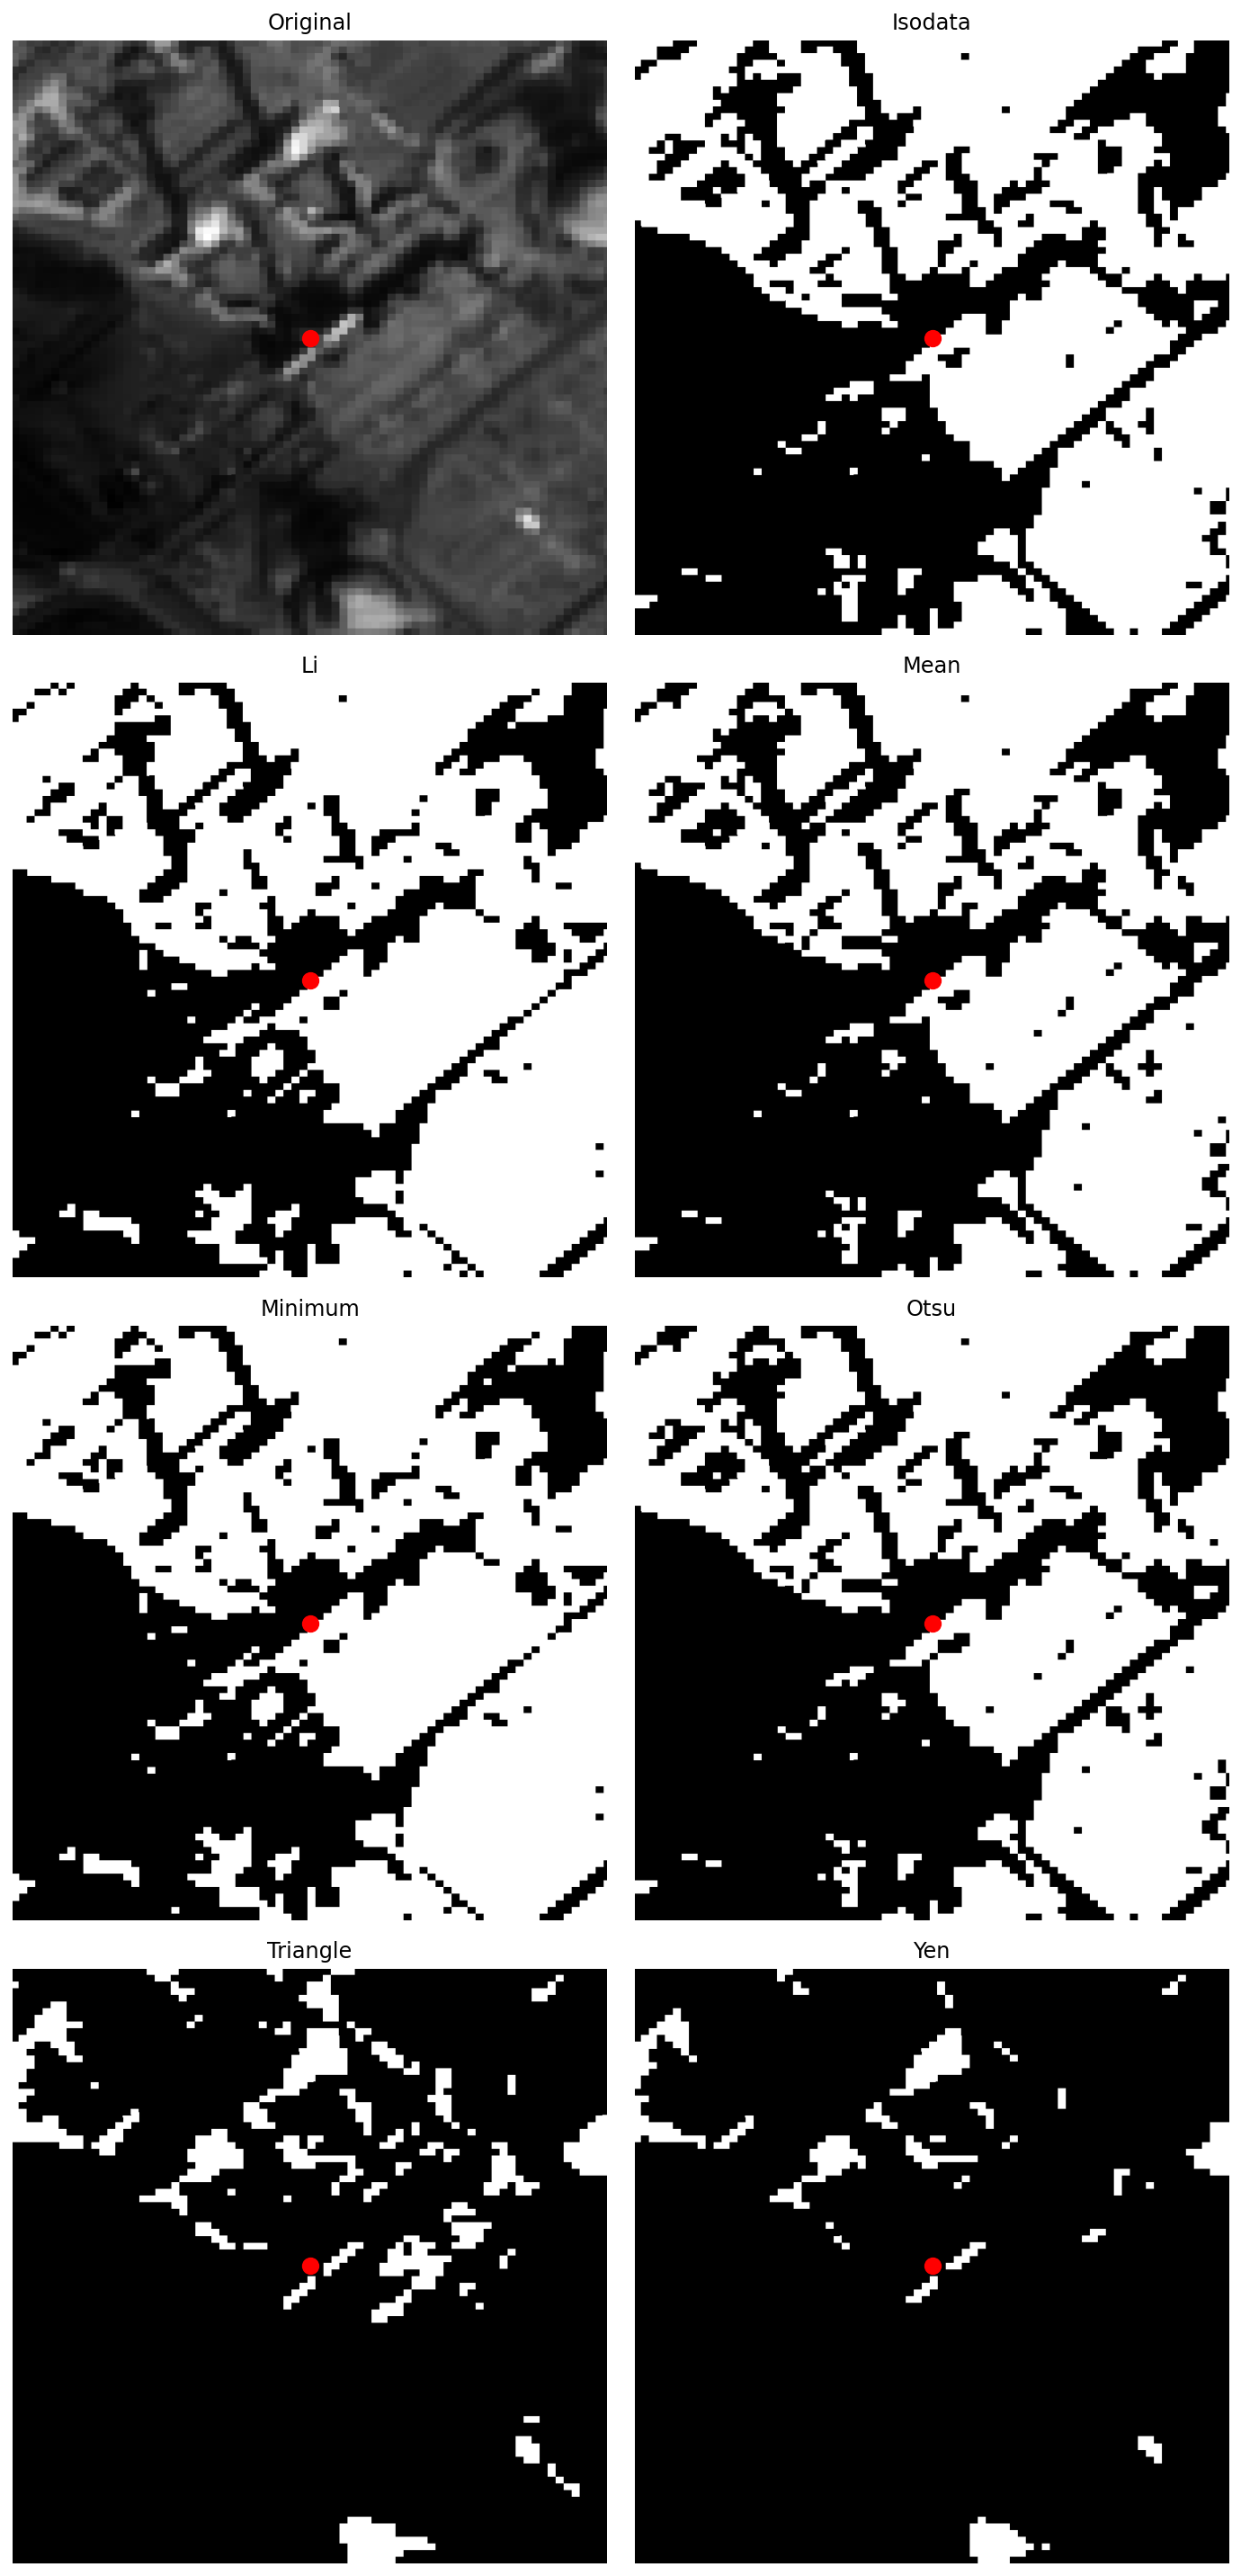

In [59]:
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold

# plot all thresholding techniques
fig, ax = try_all_threshold(img_arr_bw, figsize=(10, 20), verbose=False)

# stack base
ax[0].scatter(stack_x, stack_y, c='red', s=75, label='Stack Base')
ax[1].scatter(stack_x, stack_y, c='red', s=75, label='Stack Base')
ax[2].scatter(stack_x, stack_y, c='red', s=75, label='Stack Base')
ax[3].scatter(stack_x, stack_y, c='red', s=75, label='Stack Base')
ax[4].scatter(stack_x, stack_y, c='red', s=75, label='Stack Base')
ax[5].scatter(stack_x, stack_y, c='red', s=75, label='Stack Base')
ax[6].scatter(stack_x, stack_y, c='red', s=75, label='Stack Base')
ax[7].scatter(stack_x, stack_y, c='red', s=75, label='Stack Base')

plt.show()

#### Creating Mean Value Thresholded Image

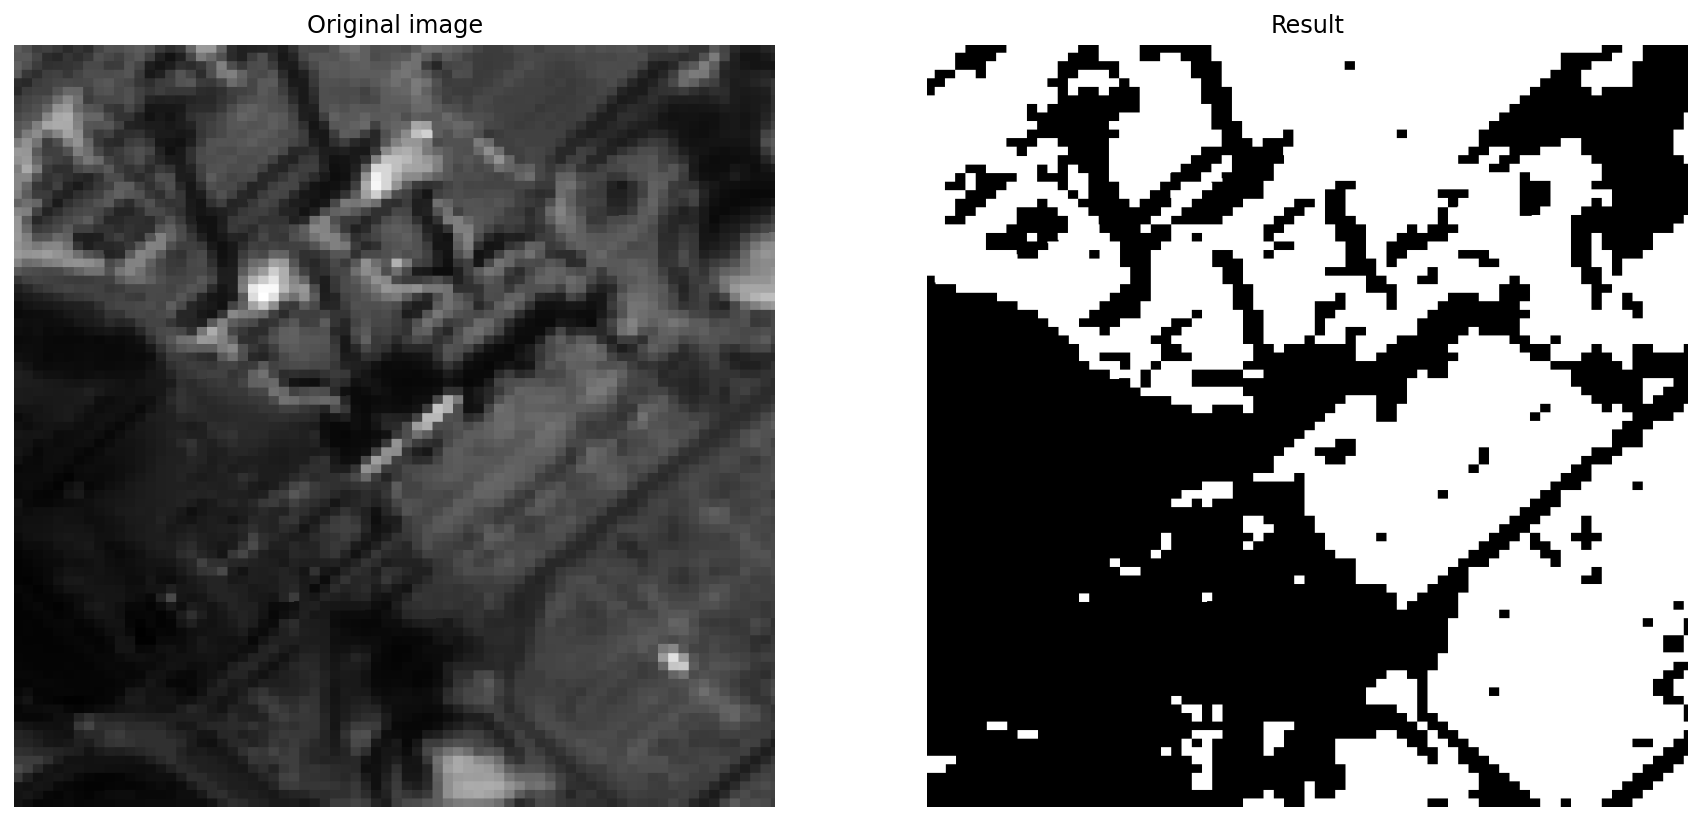

In [119]:
from skimage.filters import threshold_mean

thresh = threshold_mean(img_arr_bw)
binary = img_arr_bw > thresh
img_seg = np.where(binary == True, 0, 1)

fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(img_arr_bw, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

## Blob Creation

### Image cropping

In [120]:
# get angle
angle = 90+abs(180-158.980095438294)

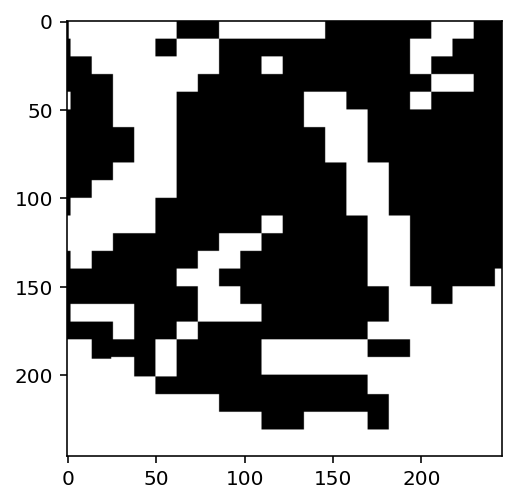

In [121]:
# crop image
img_seg_crop = img_seg[200:stack_x, 200:stack_y]
plt.imshow(img_seg_crop, cmap='gray')
plt.show()

### Connected components

In [122]:
from PIL import Image
from scipy import ndimage

In [123]:
img_seg_crop_shape = img_seg_crop.shape

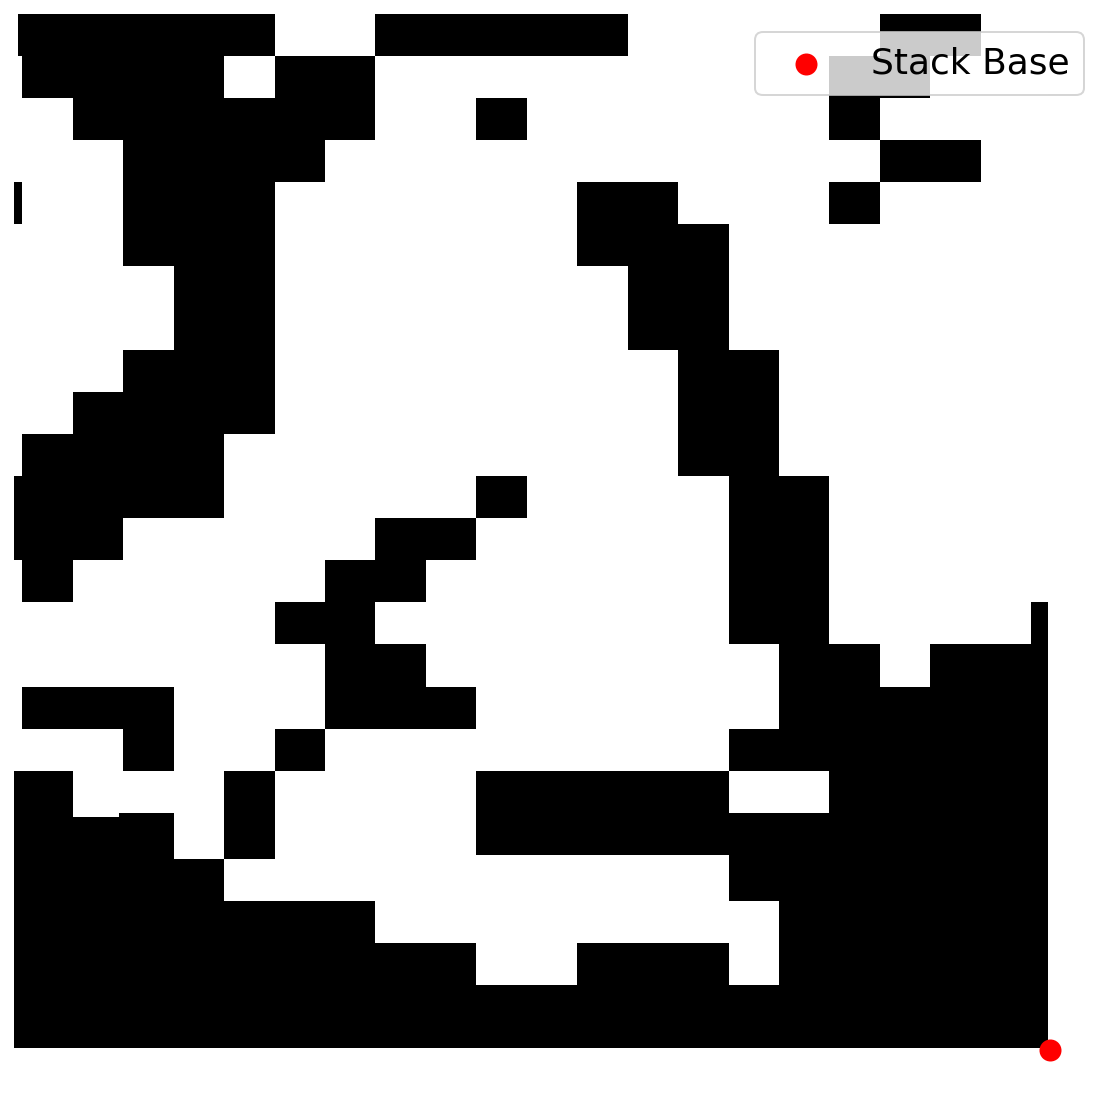

In [159]:
plt.figure(figsize=(10, 10))
im = plt.imshow(img_seg_crop, cmap='gray_r')
# plot base of power plant
plt.scatter(img_seg_crop_shape[0], img_seg_crop_shape[1], c='red', s=100, label = 'Stack Base')
plt.axis('off')
plt.legend(fontsize=18)
plt.show()

In [124]:
threshold = 0.5

# find connected components
labeled, nr_objects = ndimage.label(img_seg_crop > threshold) 
print("Number of objects is {}".format(nr_objects))

Number of objects is 13


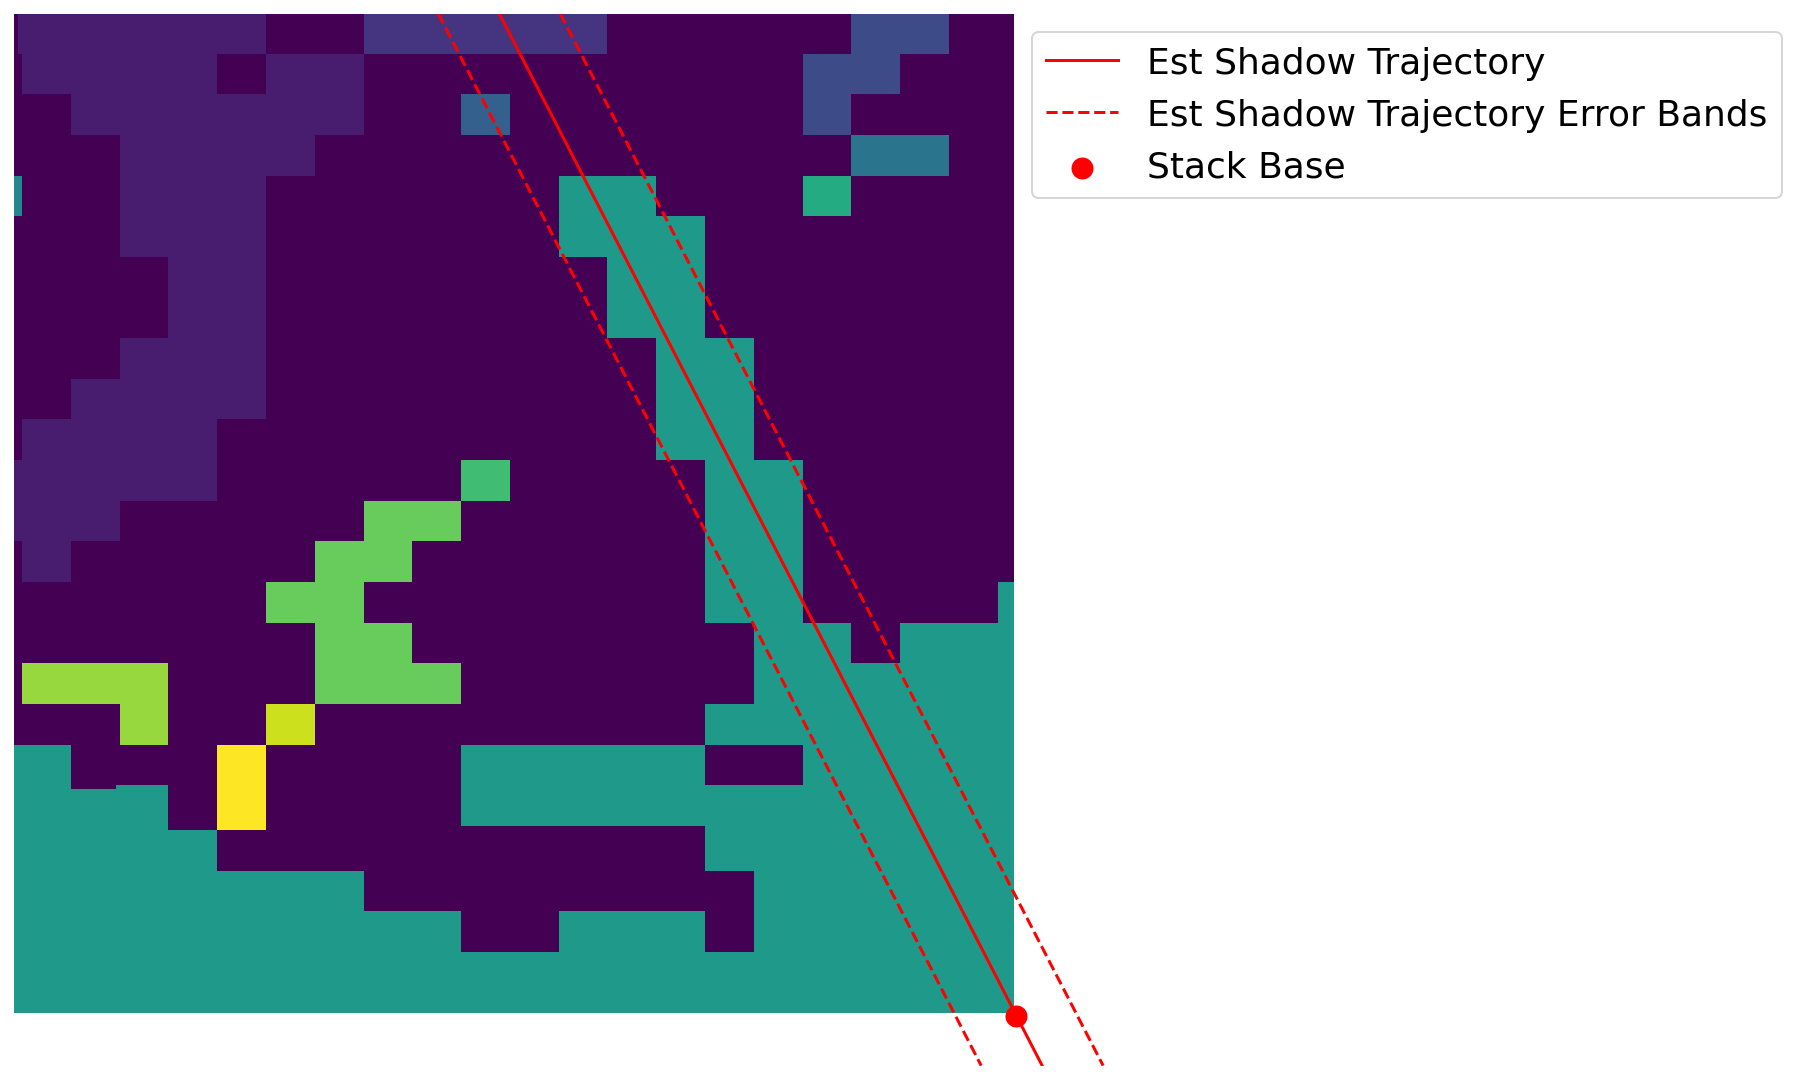

In [151]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 10))
im = plt.imshow(labeled)

# plot base of power plant
plt.scatter(img_seg_crop_shape[0], img_seg_crop_shape[1], c='red', s=100, label = 'Stack Base')

# angle lines
plt.axline((img_seg_crop_shape[0],img_seg_crop_shape[1]), slope=math.radians(angle), color='red', 
           label='Est Shadow Trajectory')

plt.axline((img_seg_crop_shape[0]-15,img_seg_crop_shape[1]), slope=math.radians(angle), color='red', 
           label='Est Shadow Trajectory Error Bands', linestyle='dashed')

plt.axline((img_seg_crop_shape[0]+15,img_seg_crop_shape[1]), slope=math.radians(angle), color='red', 
           linestyle='dashed')

values = np.unique(labeled.ravel())
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Blob {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend

# plt.legend(handles=patches, bbox_to_anchor=(0.5, 0., 1.1, 1), fontsize=18)
plt.legend(bbox_to_anchor=(0.5, 0., 1.1, 1), fontsize=18)
plt.axis('off')
plt.show()